REGRESIÓN LOGÍSTICA PARA CLASIFICACIÓN DE ENFERMEDADES DE CEBOLLA
Juan David Montaña Ariza (1804008)

In [1]:
#Importación de librerias

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#Librerias para guardar archivos
from pathlib import Path
out_dir = Path.cwd() / "Regresion Logistica" #Carpeta para guardar y cargar los modelos de Regresion Logística
out_dir.mkdir(parents=True, exist_ok=True)


Función para cargar y preparar los datos desde el CSV

In [2]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte a vectores de características.
    
    Parámetros:
    -----------
    csv_path : str
        Ruta al archivo CSV con las rutas de imágenes y clases
    tamano_imagen : tuple
        Tamaño al que se redimensionarán las imágenes (ancho, alto)
    """
    
    print("="*60)
    print("CARGANDO DATASET")
    print("="*60)
    
    # Leer el CSV
    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")
    
    # Mostrar las clases encontradas
    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")
    
    # Preparar listas para datos y etiquetas
    X = []  # Características (imágenes aplanadas)
    y = []  # Etiquetas (clases)
    errores = 0
    
    print(f"\nProcesando imágenes (tamaño: {tamano_imagen})...")
    
    # Procesar cada imagen
    for idx, fila in df.iterrows():
        try:
            # Abrir y procesar imagen
            imagen = Image.open(fila['image_path'])
            
            # Convertir a RGB si es necesario
            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')
            
            # Redimensionar
            imagen = imagen.resize(tamano_imagen)
            
            # Convertir a array y aplanar
            imagen_array = np.array(imagen).flatten()
            
            # Normalizar valores de píxeles (0-255 → 0-1)
            imagen_normalizada = imagen_array / 255.0
            
            # Agregar a las listas
            X.append(imagen_normalizada)
            y.append(fila['class'])
            
            # Mostrar progreso cada 100 imágenes
            if (idx + 1) % 100 == 0:
                print(f"   Procesadas: {idx + 1}/{len(df)}")
                
        except Exception as e:
            errores += 1
            print(f" Error en imagen {fila['image_path']}: {e}")
    
    # Convertir a arrays numpy
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nProcesamiento completado")
    print(f"   • Imágenes procesadas: {len(X)}")
    print(f"   • Errores: {errores}")
    print(f"   • Forma de X: {X.shape}")
    print(f"   • Número de características: {X.shape[1]}")
    
    return X, y, clases_unicas

Función para entrenar el modelo de Regresión Lógistica

In [3]:
def entrenar_regresion_logistica(X_train, y_train, max_iter=1000):
    """
    Entrena un modelo de Regresión Logística.
    
    Parámetros:
    -----------
    X_train : array
        Datos de entrenamiento
    y_train : array
        Etiquetas de entrenamiento
    max_iter : int
        Número máximo de iteraciones
    """
    
    print("\n" + "="*60)
    print("ENTRENANDO REGRESIÓN LOGÍSTICA")
    print("="*60)
    
    # Crear el modelo
    # multi_class='multinomial' para múltiples clases
    # solver='lbfgs' funciona bien para datasets pequeños-medianos
    modelo = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=max_iter,
        random_state=42,
        verbose=0
    )
    
    print("Entrenando modelo...")
    print(f"   • Algoritmo: Regresión Logística Multinomial")
    print(f"   • Solver: LBFGS")
    print(f"   • Máx iteraciones: {max_iter}")
    
    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    
    print("Modelo entrenado exitosamente!")
    
    return modelo

Función para Evaluar el Modelo

In [4]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas.
    
    Parámetros:
    -----------
    modelo : LogisticRegression
        Modelo entrenado
    X_test : array
        Datos de prueba
    y_test : array
        Etiquetas reales de prueba
    nombres_clases : array
        Nombres de las clases
    """
    
    print("\n" + "="*60)
    print("EVALUACIÓN DEL MODELO")
    print("="*60)
    
    # Hacer predicciones
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Mostrar reporte de clasificación
    print("\nREPORTE DETALLADO POR CLASE:")
    print("-"*60)
    reporte = classification_report(y_test, y_pred, target_names=nombres_clases)
    print(reporte)
    
    # Calcular y mostrar matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)
    
    return accuracy, y_pred, matriz_confusion

Función para visualizar la matriz de Confusión

In [5]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Crea una visualización de la matriz de confusión.
    
    Parámetros:
    -----------
    matriz_confusion : array
        Matriz de confusión
    nombres_clases : array
        Nombres de las clases
    """
    
    plt.figure(figsize=(12, 10))
    
    # Crear heatmap
    sns.heatmap(matriz_confusion, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases)
    
    plt.title('Matriz de Confusión - Regresión Logística', fontsize=16)
    plt.ylabel('Clase Real', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Guardar figura
    plt.savefig(out_dir / 'matriz_confusion_logistica.png', dpi=100, bbox_inches='tight')
    print("\nMatriz de confusión guardada como 'matriz_confusion_logistica.png'")
    plt.show()

Función para Predecir nueva imagen

In [6]:
def predecir_imagen(ruta_imagen, modelo_path=out_dir/'modelo_regresion_logistica.pkl'):
    """
    Función para predecir una nueva imagen.
    
    Uso:
    ----
    predecir_imagen('ruta/imagen.jpg')
    """
    import joblib
    
    # Cargar modelo y transformadores
    modelo = joblib.load(modelo_path)
    scaler = joblib.load(out_dir/'scaler.pkl')
    label_encoder = joblib.load(out_dir/'label_encoder.pkl')
    
    # Procesar imagen
    imagen = Image.open(ruta_imagen)
    if imagen.mode != 'RGB':
        imagen = imagen.convert('RGB')
    imagen = imagen.resize((32, 32))
    imagen_array = np.array(imagen).flatten() / 255.0
    imagen_array = imagen_array.reshape(1, -1)
    
    # Escalar
    imagen_scaled = scaler.transform(imagen_array)
    
    # Predecir
    prediccion = modelo.predict(imagen_scaled)[0]
    probabilidades = modelo.predict_proba(imagen_scaled)[0]
    
    # Decodificar
    clase_predicha = label_encoder.inverse_transform([prediccion])[0]
    
    # Mostrar la imagen con el resultado
    plt.figure()
    plt.imshow(imagen)
    plt.axis('off')
    plt.title(f"Predicción: {clase_predicha}  |  Confianza: {max(probabilidades):.2%}")
    
    print(f"\n PREDICCIÓN:")
    print(f"   Clase: {clase_predicha}")
    print(f"   Confianza: {max(probabilidades):.2%}")
    
    return clase_predicha

Parametros para Modelo

In [7]:
CSV_PATH = "onion_dataset.csv"  # <-- Nombre Data_set
TAMANO_IMAGEN = (32, 32)        # <-- Tamaño de imagen 
TEST_SIZE = 0.2                 # <-- 20% para prueba
MAX_ITER = 1000                 # <-- Iteraciones máximas

Entrenamiento del Modelo

In [8]:
 # 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight

Procesando imágenes (tamaño: (32, 32))...
   Procesadas: 100/13229
   Procesadas: 200/13229
   Procesadas: 300/13229
   Procesadas: 400/13229
   Procesadas: 500/13229
   Procesadas: 600/13229
   Procesadas: 700/13229
   Procesadas: 800/13229
   Procesadas: 900/13229
   Procesadas: 1000/13229
   Procesadas: 1100/13229
   Procesadas: 1200/13229
   Procesadas: 1300/13229
   Procesadas: 1400/13229
   Procesadas: 1500/13229
   Procesadas: 1600/13229
   Procesadas: 1700/13229
   Procesadas: 1800/13229
   Procesadas: 1900/13229
   Procesadas: 2000/13229
   Procesadas: 2100/13229
   Procesadas: 2

In [9]:
# 2. Codificar etiquetas (convertir nombres a números)
print("\nCodificando etiquetas...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


Codificando etiquetas...


In [10]:
# 3. Dividir en entrenamiento y prueba
print("\nDividiendo datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=42,
    stratify=y_encoded  # Mantener proporción de clases
)
print(f"   • Entrenamiento: {len(X_train)} imágenes")
print(f"   • Prueba: {len(X_test)} imágenes")


Dividiendo datos...
   • Entrenamiento: 10583 imágenes
   • Prueba: 2646 imágenes


In [11]:
# 4. Escalar características 
print("\nEscalando características...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Características escaladas (media=0, std=1)")


Escalando características...
 Características escaladas (media=0, std=1)


In [12]:
# 5. Entrenar modelo
modelo = entrenar_regresion_logistica(X_train_scaled, y_train, MAX_ITER)


ENTRENANDO REGRESIÓN LOGÍSTICA
Entrenando modelo...
   • Algoritmo: Regresión Logística Multinomial
   • Solver: LBFGS
   • Máx iteraciones: 1000
Modelo entrenado exitosamente!


In [13]:
# 6. Evaluar modelo
accuracy, y_pred, matriz = evaluar_modelo(
    modelo, 
    X_test_scaled, 
    y_test,
    label_encoder.classes_
)


EVALUACIÓN DEL MODELO

ACCURACY GENERAL: 0.5813 (58.13%)

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.60      0.63      0.62       166
     Botrytis Leaf Blight       0.37      0.31      0.34        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       0.95      0.97      0.96        79
            Caterpillar-P       0.73      0.88      0.80       312
             Downy mildew       0.00      0.00      0.00         7
               Fusarium-D       0.66      0.72      0.69       255
           Healthy leaves       0.64      0.63      0.63       688
Iris yellow virus_augment       0.40      0.37      0.38       380
            Purple blotch       0.30      0.30      0.30       170
                     Rust       0.39      0.42      0.40        43
                Virosis-D       0.72      0.84


Matriz de confusión guardada como 'matriz_confusion_logistica.png'


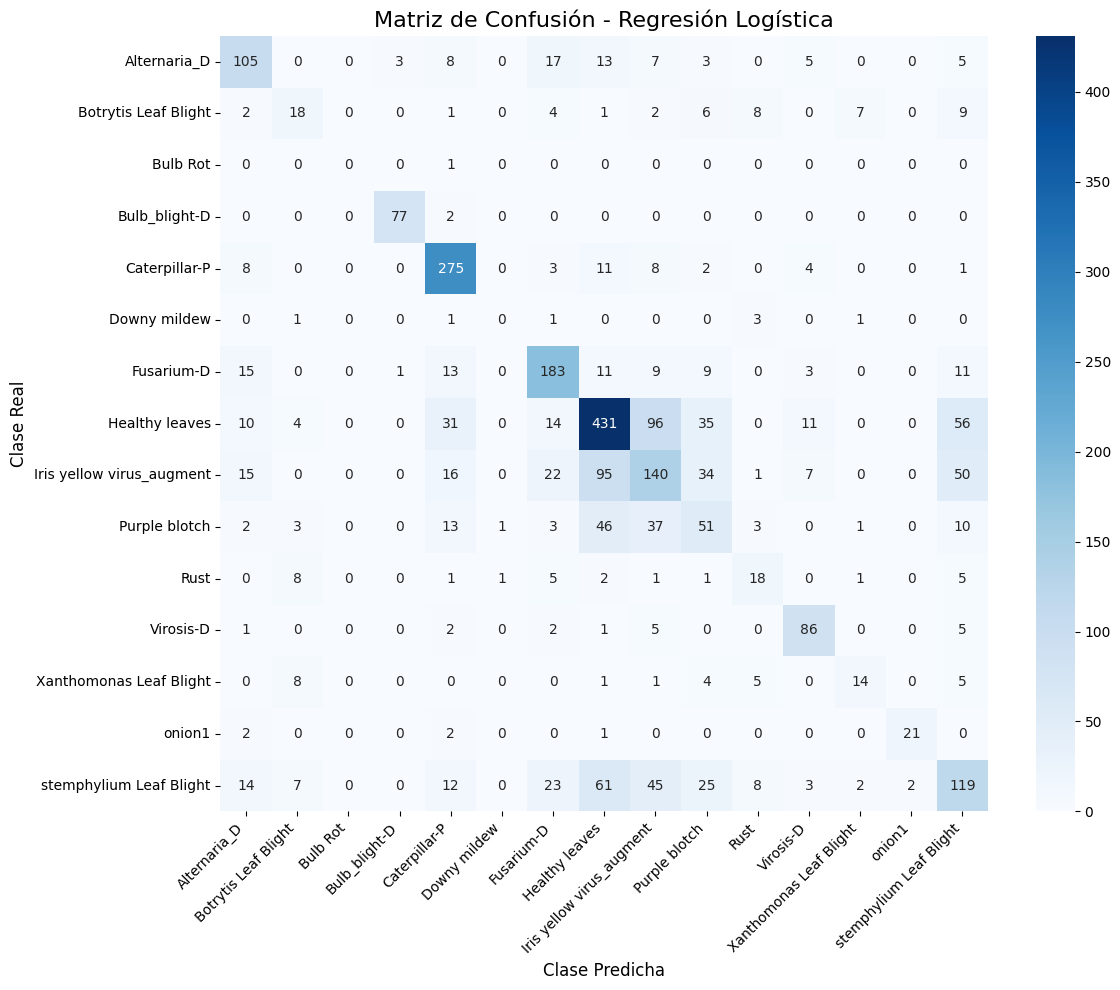

In [14]:
# 7. Visualizar matriz de confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)

In [15]:
# 8. Guardar modelo 
import joblib

joblib.dump(modelo, out_dir / 'modelo_regresion_logistica.pkl')
joblib.dump(scaler, out_dir / 'scaler.pkl')
joblib.dump(label_encoder, out_dir / 'label_encoder.pkl')

print(f"\nArchivos guardados en: {out_dir.resolve()}")


Archivos guardados en: C:\Cosas Varias\Universidad\10 Decimo Semestre\Machine Learning\Proyecto\Regresion Logistica


In [16]:
# Análisis de rendimiento por clase
print("\nANÁLISIS POR CLASE:")
print("-"*60)
accuracies_por_clase = matriz.diagonal() / matriz.sum(axis=1)
for i, clase in enumerate(label_encoder.classes_):
    acc_clase = accuracies_por_clase[i]
    total_clase = matriz.sum(axis=1)[i]
    print(f"{clase:30s}: {acc_clase:.2%} accuracy ({total_clase} muestras)")


ANÁLISIS POR CLASE:
------------------------------------------------------------
Alternaria_D                  : 63.25% accuracy (166 muestras)
Botrytis Leaf Blight          : 31.03% accuracy (58 muestras)
Bulb Rot                      : 0.00% accuracy (1 muestras)
Bulb_blight-D                 : 97.47% accuracy (79 muestras)
Caterpillar-P                 : 88.14% accuracy (312 muestras)
Downy mildew                  : 0.00% accuracy (7 muestras)
Fusarium-D                    : 71.76% accuracy (255 muestras)
Healthy leaves                : 62.65% accuracy (688 muestras)
Iris yellow virus_augment     : 36.84% accuracy (380 muestras)
Purple blotch                 : 30.00% accuracy (170 muestras)
Rust                          : 41.86% accuracy (43 muestras)
Virosis-D                     : 84.31% accuracy (102 muestras)
Xanthomonas Leaf Blight       : 36.84% accuracy (38 muestras)
onion1                        : 80.77% accuracy (26 muestras)
stemphylium Leaf Blight       : 37.07% accuracy

Prueba de Modelo con Imagenes


 PREDICCIÓN:
   Clase: Rust
   Confianza: 49.23%


'Rust'

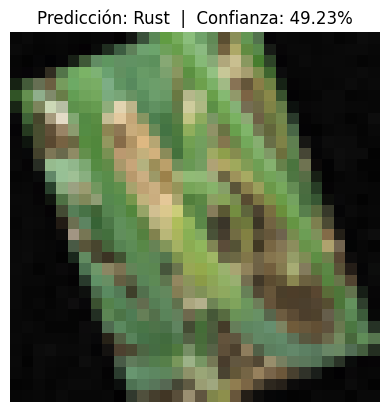

In [17]:
predecir_imagen('Imagenes_Prueba/Downy.jpg')


 PREDICCIÓN:
   Clase: Alternaria_D
   Confianza: 95.58%


'Alternaria_D'

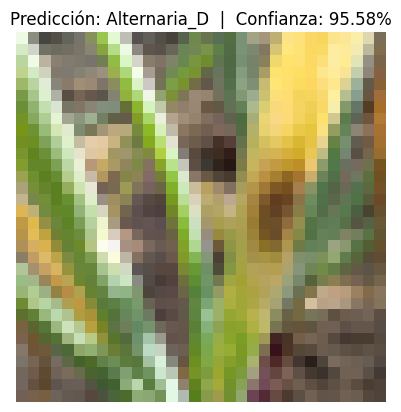

In [18]:
predecir_imagen('Imagenes_Prueba/Alternaria.jpg')


 PREDICCIÓN:
   Clase: Iris yellow virus_augment
   Confianza: 83.11%


'Iris yellow virus_augment'

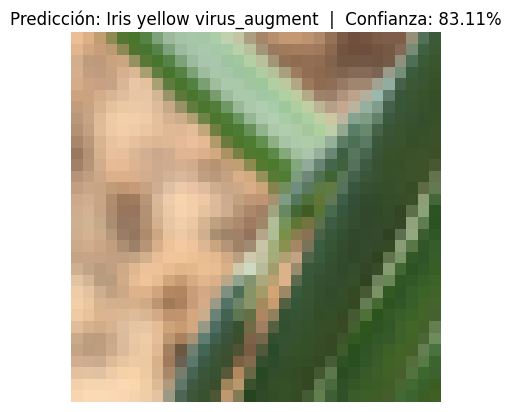

In [19]:
predecir_imagen('Imagenes_Prueba/Iris.jpg')


 PREDICCIÓN:
   Clase: Purple blotch
   Confianza: 96.08%


'Purple blotch'

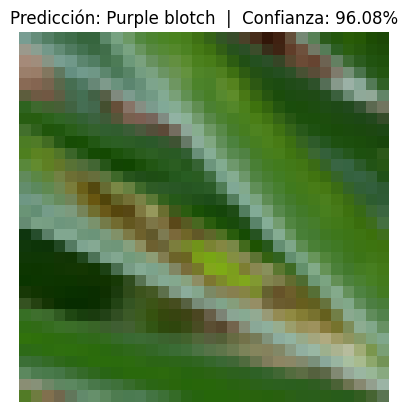

In [20]:
predecir_imagen('Imagenes_Prueba/Purple.jpg')